In [9]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rc('font', size=14)
import seaborn as sns
import statsmodels.api as smf
sns.set(style='whitegrid', color_codes=True, rc={'figure.figsize':(11,8)}, font_scale=2)

from sklearn.linear_model import Lasso, LassoCV, LassoLarsIC
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix


In [10]:
import sys
sys.path.append('/classes/20800_winter2023/')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Classifier Boundary (KNN and Logistic Regression)

In [55]:
# DGP

from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn import neighbors
from sklearn import linear_model
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

np.random.seed(0)

n_samples = 1500

# Generate data    
noisy_circles = make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = make_moons(n_samples=n_samples, noise=0.05)
balanced = make_blobs(n_samples=n_samples, random_state=8,centers=2,center_box = (-10,10))

In [56]:
def split(X,y,test_size):
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=42)
    return X,X_train, X_test, y_train, y_test

### KNN boundary

In [57]:
def knn(X_train,y_train,n_neighbors):
    #Fit the K-nn model
    clf = neighbors.KNeighborsClassifier(n_neighbors)
    clf.fit(X_train, y_train)
    return clf

In [58]:
def visualize_knn(clf,h,X,X_train,ytrain,X_test,y_test,n_neighbors):
    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),                         
                         np.arange(y_min, y_max, h))


    # Put the result into a color plot


    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize = (8,8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training and testing points
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold,
                edgecolor='k', s=20, marker='^')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)"
              % (n_neighbors))
    print("{:<40} {:.4f}".format("Train Score:", clf.score(X_train, y_train)))
    print("{:<40} {:.4f}".format("Test Score:", clf.score(X_test, y_test)))

    plt.show()

Train Score:                             1.0000
Test Score:                              1.0000


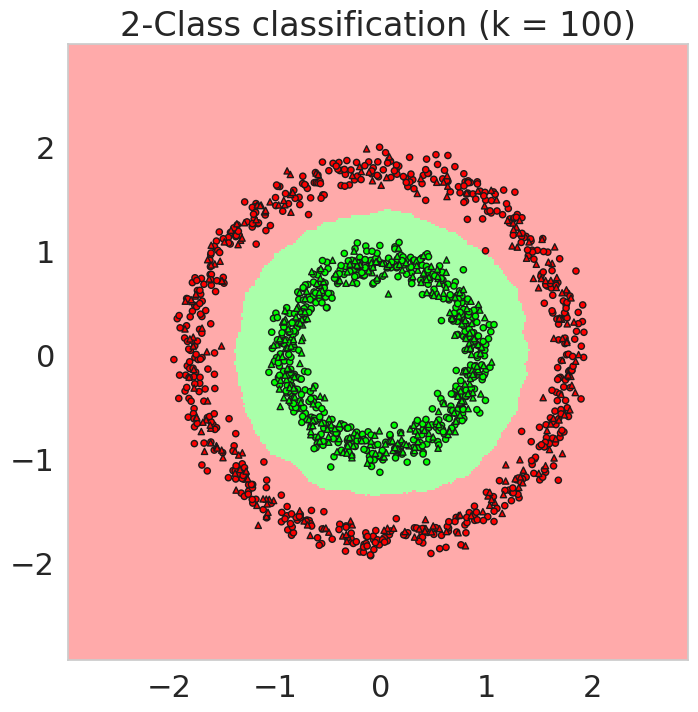

In [59]:
# Circle shape dataset
X,y = noisy_circles
X,X_train, X_test, y_train, y_test = split(X,y,.3)
clf = knn(X_train,y_train,100)
visualize_knn(clf,.02,X,X_train,y_train,X_test,y_test,100)

Train Score:                             0.9962
Test Score:                              0.9978


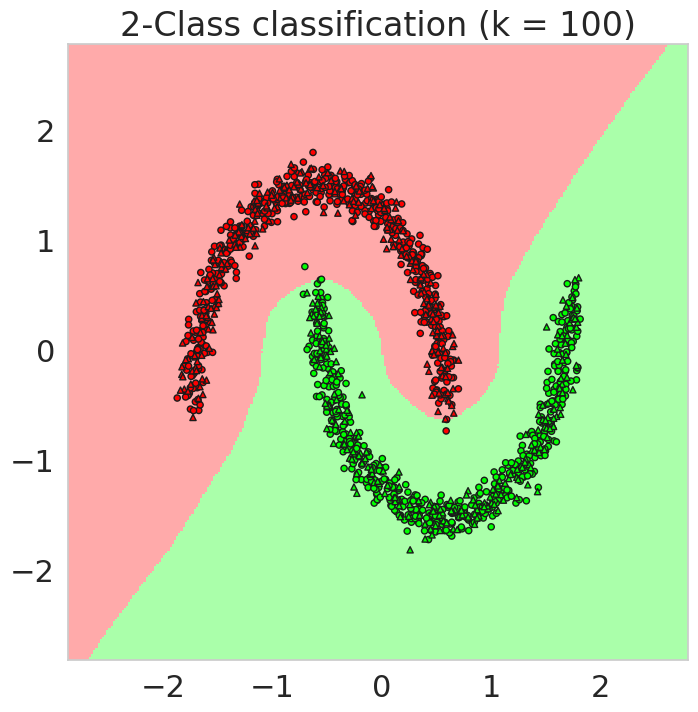

In [60]:
X,y = noisy_moons
X,X_train, X_test, y_train, y_test = split(X,y,.3)
clf = knn(X_train,y_train,100)
visualize_knn(clf,.02,X,X_train,y_train,X_test,y_test,100)

Train Score:                             1.0000
Test Score:                              1.0000


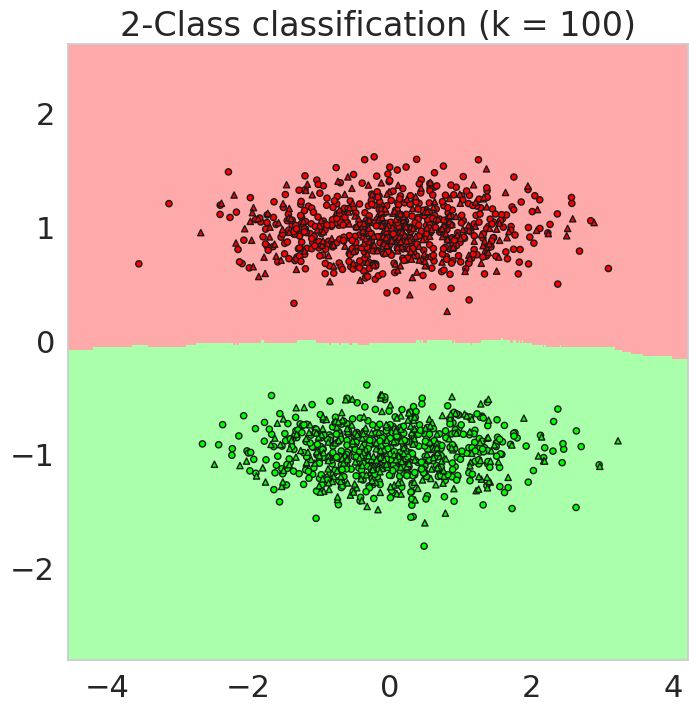

In [61]:
X,y = balanced
X, X_train, X_test, y_train, y_test = split(X,y,.3)
clf = knn(X_train,y_train,100)
visualize_knn(clf,.02,X,X_train,y_train,X_test,y_test,100)

### Logistic regression boundary

In [62]:
def logit_smf(X_train,y_train,degree,method):
    #Fit the logistic regression model
    res = np.column_stack((np.ones((X_train.shape[0],1)),X_train))
    if (degree>1):
        for i in range(2, degree + 1):
            for j in range(0, i + 1):
                res = np.column_stack((res, (X_train[:,0] ** (i - j)) * (X_train[:,1] ** j)))
    logit = smf.Logit(y_train, res)
    if method == 'l1':
        result = logit.fit_regularized(method='l1')
    if method == 'none':
        result = logit.fit()
    return result

In [63]:
def visualize_logit_smf(clf,h,X,X_train,ytrain,X_test,y_test,degree):
    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),                         
                         np.arange(y_min, y_max, h))


    # Put the result into a color plot
    xxs = xx.ravel()
    yys = yy.ravel()
    res = np.column_stack((np.ones((xxs.shape[0],1)),np.c_[xxs,yys]))
    if (degree>1):
        for i in range(2, degree + 1):
            for j in range(0, i + 1):
                res = np.column_stack((res, (xxs ** (i - j)) * (yys ** j)))

    Z = np.array(list(map(round,clf.predict(res))))
    Z = Z.reshape(xx.shape)
    plt.figure(figsize = (8,8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training and testing points
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold,
                edgecolor='k', s=20, marker='^')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (degree = %i)"
              % (degree))
    
    res_train = np.column_stack((np.ones((X_train.shape[0],1)),X_train))
    if (degree>1):
        for i in range(2, degree + 1):
            for j in range(0, i + 1):
                res_train = np.column_stack((res_train, (X_train[:,0] ** (i - j)) * (X_train[:,1] ** j)))
    train_acc = (np.array(list(map(round,clf.predict(res_train)))) == y_train).sum()/len(y_train)
    print("{:<40} {:.4f}".format("Train Score:", train_acc))
    
    res_test = np.column_stack((np.ones((X_test.shape[0],1)),X_test))
    if (degree>1):
        for i in range(2, degree + 1):
            for j in range(0, i + 1):
                res_test = np.column_stack((res_test, (X_test[:,0] ** (i - j)) * (X_test[:,1] ** j)))
    test_acc = (np.array(list(map(round,clf.predict(res_test)))) == y_test).sum()/len(y_test)
    print("{:<40} {:.4f}".format("Test Score:", test_acc))

    plt.show()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6882228463844812
            Iterations: 11
            Function evaluations: 12
            Gradient evaluations: 11
Train Score:                             0.5307
Test Score:                              0.4782


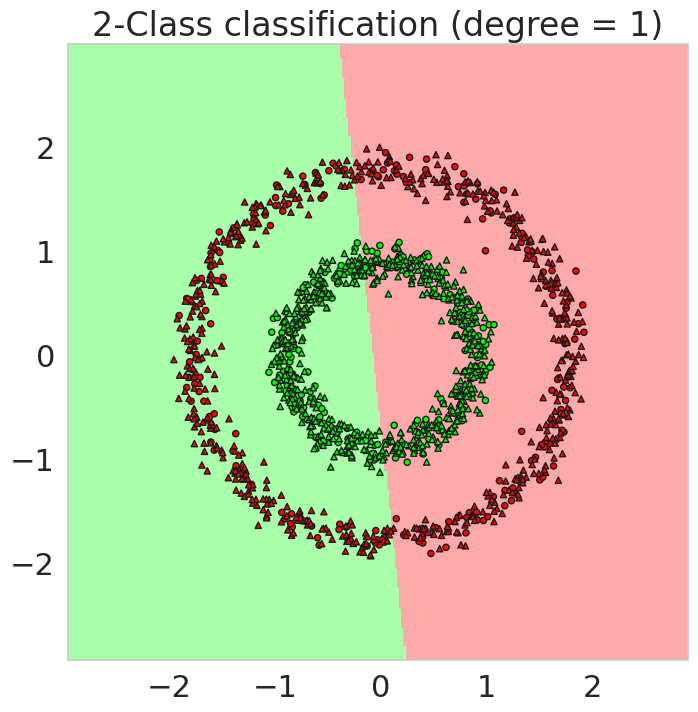

In [64]:
# Circle shape dataset
X,y = noisy_circles
X,X_train, X_test, y_train, y_test = split(X,y,.75)
# clf = logit(X_train,y_train,1)
result = logit_smf(X_train,y_train,1,'l1')
visualize_logit(result,.02,X,X_train,y_train,X_test,y_test,1)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.441242072520461e-10
            Iterations: 39
            Function evaluations: 39
            Gradient evaluations: 39
Train Score:                             1.0000
Test Score:                              1.0000


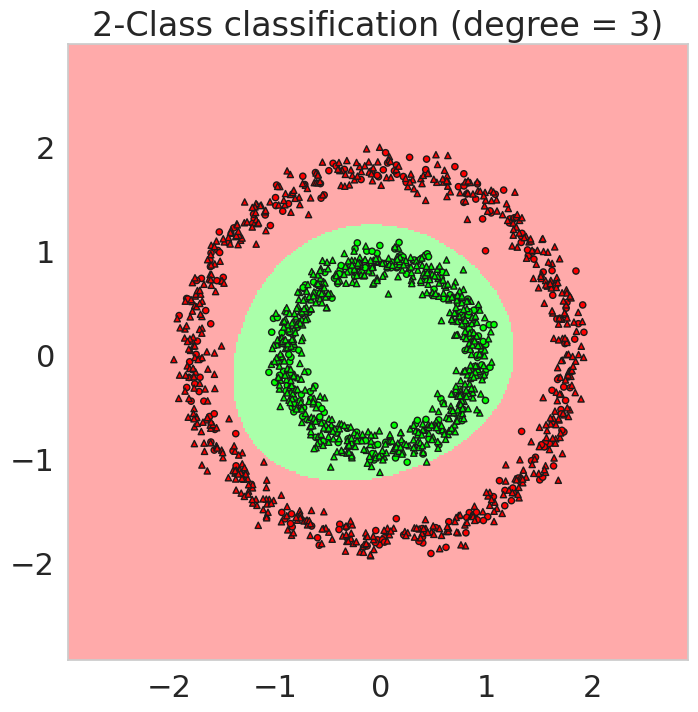

In [65]:
degree = 3
result = logit_smf(X_train,y_train,degree,'l1')
visualize_logit_smf(result,.02,X,X_train,y_train,X_test,y_test,degree)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.23142787028652465
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Train Score:                             0.8962
Test Score:                              0.8511


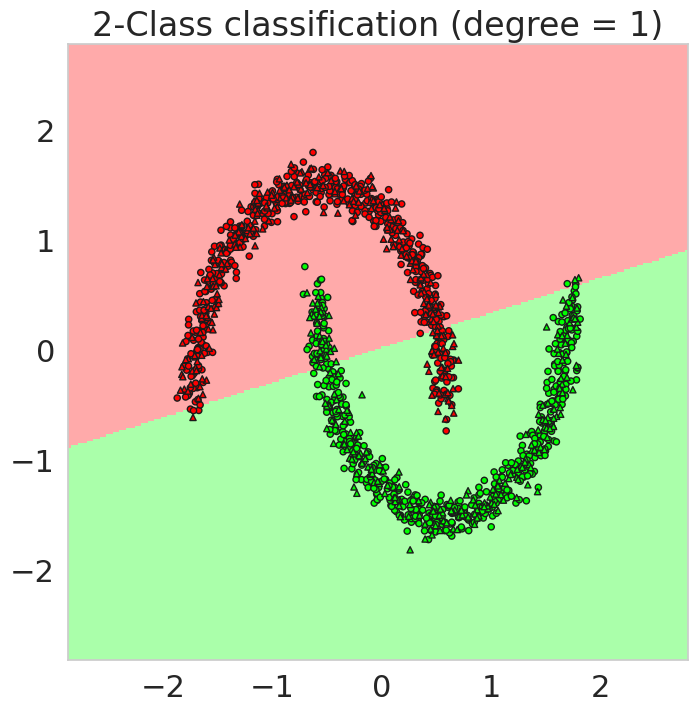

In [66]:
X,y = noisy_moons
degree = 1
X,X_train, X_test, y_train, y_test = split(X,y,.3)
result = logit_smf(X_train,y_train,degree,method = 'l1')
visualize_logit_smf(result,.02,X,X_train,y_train,X_test,y_test,degree)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3127166559047996e-10
            Iterations: 56
            Function evaluations: 56
            Gradient evaluations: 56
Train Score:                             1.0000
Test Score:                              1.0000


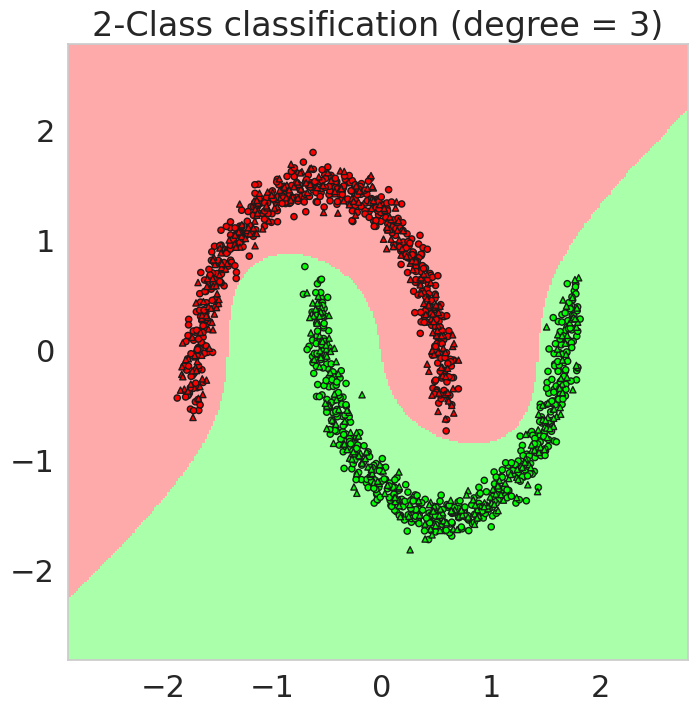

In [67]:
degree = 3
result = logit_smf(X_train,y_train,degree,method = 'l1')
visualize_logit_smf(result,.02,X,X_train,y_train,X_test,y_test,degree)

### Perfect seperation

         Current function value: 0.000000
         Iterations: 35
Train Score:                             1.0000
Test Score:                              1.0000


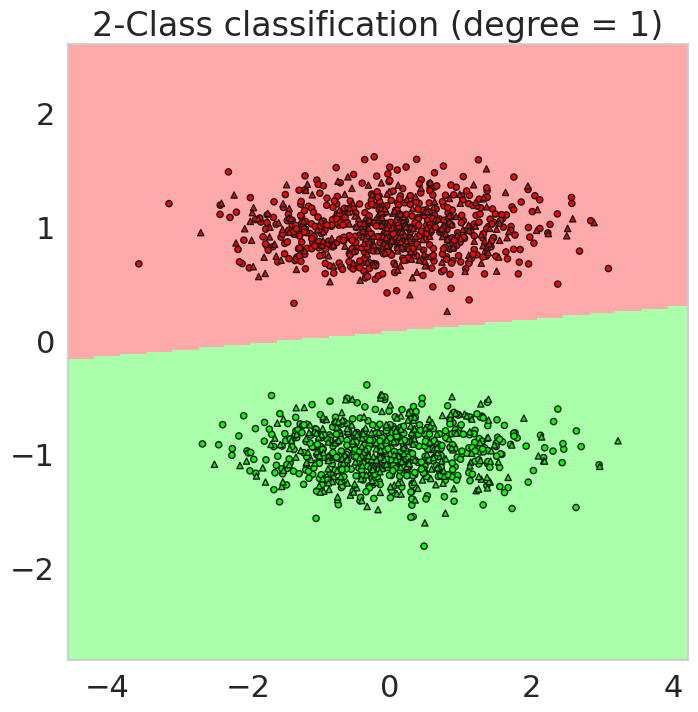

In [68]:
X,y = balanced
degree = 1
X,X_train, X_test, y_train, y_test = split(X,y,.3)
result = logit_smf(X_train,y_train,degree,method = 'none')
visualize_logit(result,.02,X,X_train,y_train,X_test,y_test,degree)

### SKlearn package fails to detect perfect seperation

In [69]:
def logit_sklearn(X_train,y_train,degree):
    #Fit the logistic regression model
    res = X_train
    if (degree>1):
        for i in range(2, degree + 1):
            for j in range(0, i + 1):
                res = np.column_stack((res, (X_train[:,0] ** (i - j)) * (X_train[:,1] ** j)))
    clf = linear_model.LogisticRegression(random_state=0).fit(res, y_train)
    return clf

In [70]:
def visualize_logit_sklearn(clf,h,X,X_train,ytrain,X_test,y_test,degree):
    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),                         
                         np.arange(y_min, y_max, h))


    # Put the result into a color plot
    xxs = xx.ravel()
    yys = yy.ravel()
    res = np.c_[xxs,yys]
    if (degree>1):
        for i in range(2, degree + 1):
            for j in range(0, i + 1):
                res = np.column_stack((res, (xxs ** (i - j)) * (yys ** j)))

    Z = clf.predict(res)
    Z = Z.reshape(xx.shape)
    plt.figure(figsize = (8,8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training and testing points
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold,
                edgecolor='k', s=20, marker='^')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (degree = %i)"
              % (degree))
    
    res_train = X_train
    if (degree>1):
        for i in range(2, degree + 1):
            for j in range(0, i + 1):
                res_train = np.column_stack((res_train, (X_train[:,0] ** (i - j)) * (X_train[:,1] ** j)))
    print("{:<40} {:.4f}".format("Train Score:", clf.score(res_train, y_train)))
    
    res_test = X_test
    if (degree>1):
        for i in range(2, degree + 1):
            for j in range(0, i + 1):
                res_test = np.column_stack((res_test, (X_test[:,0] ** (i - j)) * (X_test[:,1] ** j)))
    
    print("{:<40} {:.4f}".format("Test Score:", clf.score(res_test, y_test)))

    plt.show()

Train Score:                             1.0000
Test Score:                              1.0000


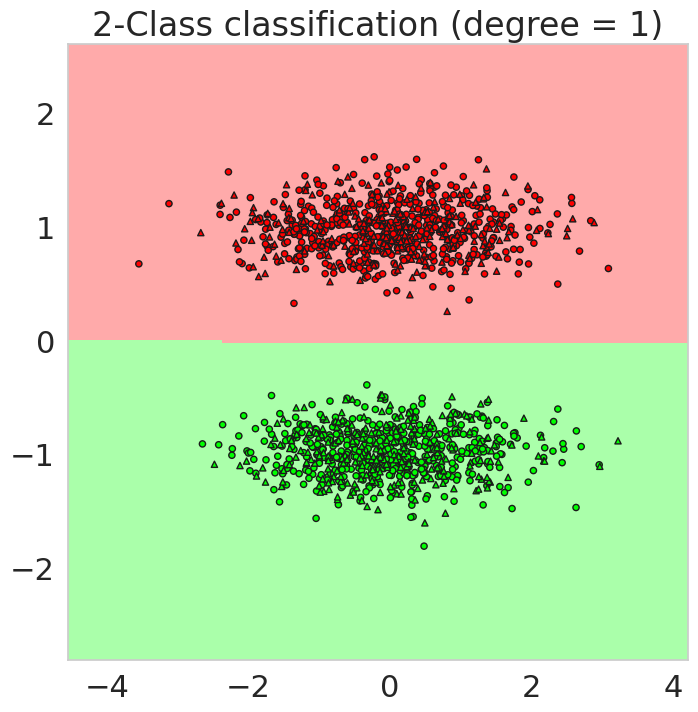

In [71]:
clf = logit_sklearn(X_train,y_train,1)
visualize_logit_sklearn(clf,.02,X,X_train,y_train,X_test,y_test,1)

# Data visualization

In [31]:
_DATA_DIR = '/classes/20800_winter2024/Data'

In [32]:
df = pd.read_csv('%s/loan_train_07_18.csv'%(_DATA_DIR), index_col =0)

In [33]:
# Data preprocessing, change string type x % to x.
df.revol_util = df.revol_util.apply(lambda x: str(x)[:-1])
df.revol_util = df.revol_util.replace('na','0')
df.revol_util = df.revol_util.astype(np.float64)

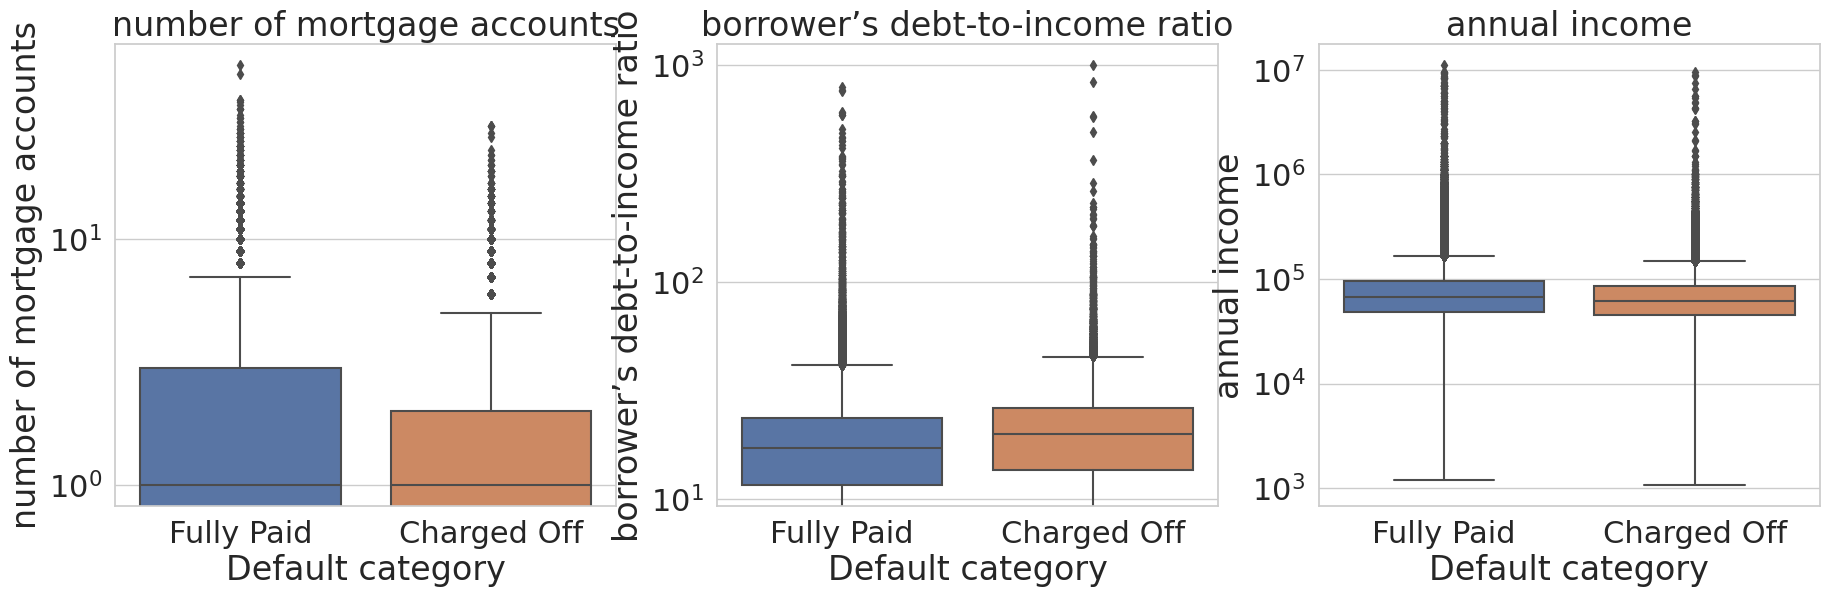

In [34]:
plt.figure(figsize=(22, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x="loan_status", y="mort_acc", data=df)

plt.title('number of mortgage accounts')
plt.xlabel('Default category')
plt.ylabel('number of mortgage accounts')
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x="loan_status", y="dti", data=df)

plt.title('borrower’s debt-to-income ratio')
plt.xlabel('Default category')
plt.ylabel('borrower’s debt-to-income ratio')
plt.yscale('log')

plt.subplot(1, 3, 3)
sns.boxplot(x="loan_status", y="annual_inc", data=df)

plt.title('annual income')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Default category')
plt.ylabel('annual income')
plt.yscale('log')



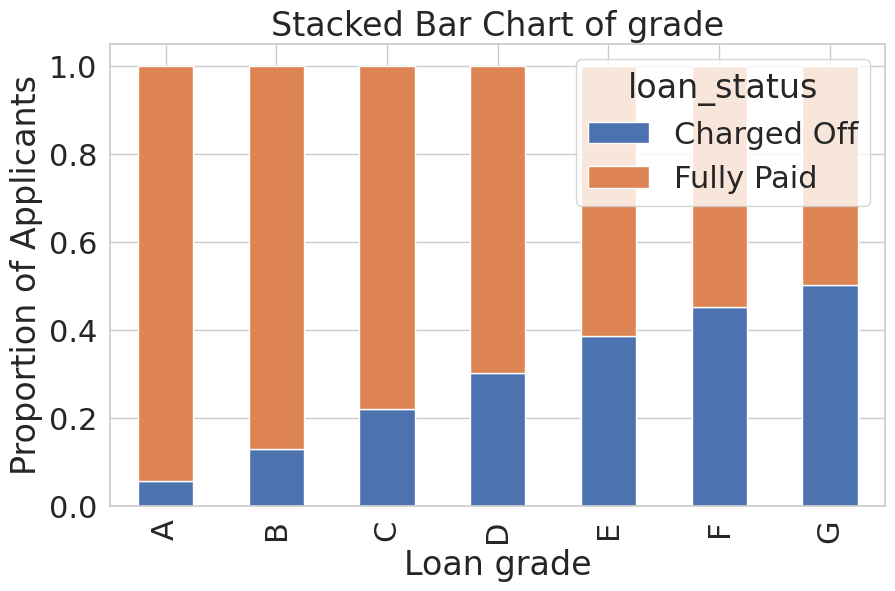

In [35]:
tablegrade = pd.crosstab(df['grade'], df.loan_status)
tablegrade.div(tablegrade.sum(1).astype(float), axis=0).plot(kind='bar', stacked = True,figsize = (10,6))
plt.title('Stacked Bar Chart of grade')
plt.xlabel('Loan grade')
plt.ylabel('Proportion of Applicants')
plt.show();

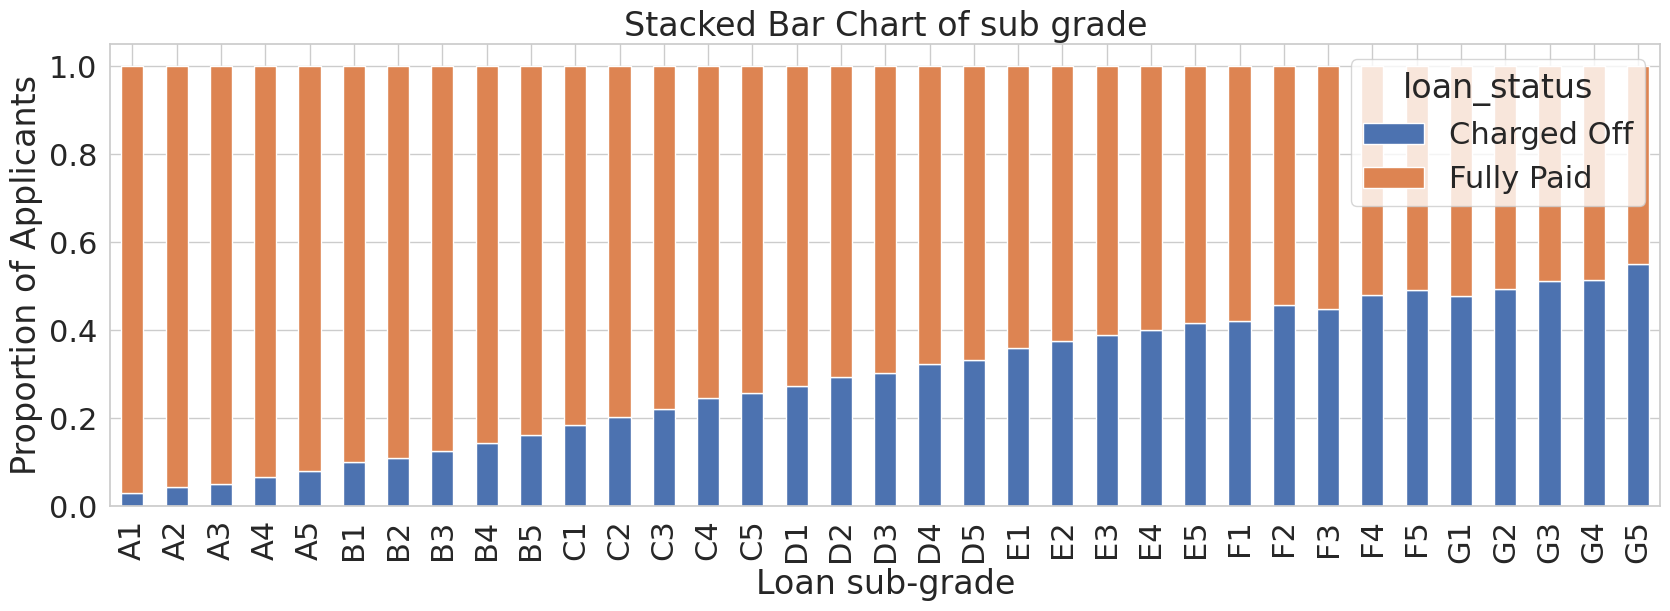

In [36]:
tablesub = pd.crosstab(df['sub_grade'], df.loan_status)
tablesub.div(tablesub.sum(1).astype(float), axis=0).plot(kind='bar', stacked = True,figsize = (20,6))
plt.title('Stacked Bar Chart of sub grade')
plt.xlabel('Loan sub-grade')
plt.ylabel('Proportion of Applicants')
plt.show();

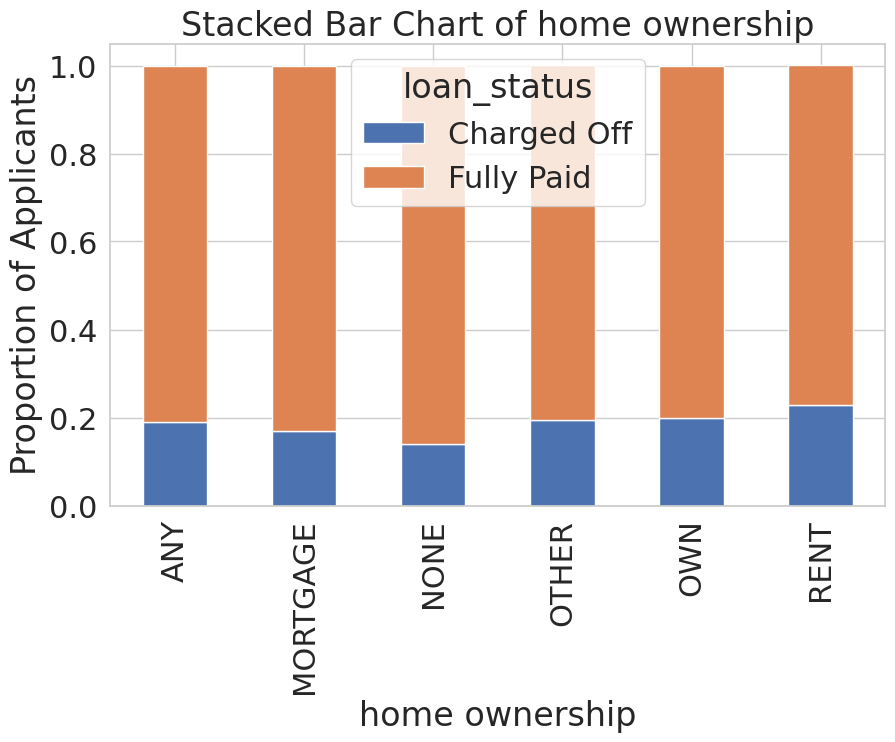

In [37]:
tablehome = pd.crosstab(df['home_ownership'], df.loan_status)
tablehome.div(tablehome.sum(1).astype(float), axis=0).plot(kind='bar', stacked = True,figsize = (10,6))
plt.title('Stacked Bar Chart of home ownership')
plt.xlabel('home ownership')
plt.ylabel('Proportion of Applicants')
plt.show();

In [38]:
temp = df.loc[:,['int_rate','sub_grade','grade']]

<Axes: xlabel='grade', ylabel='int_rate'>

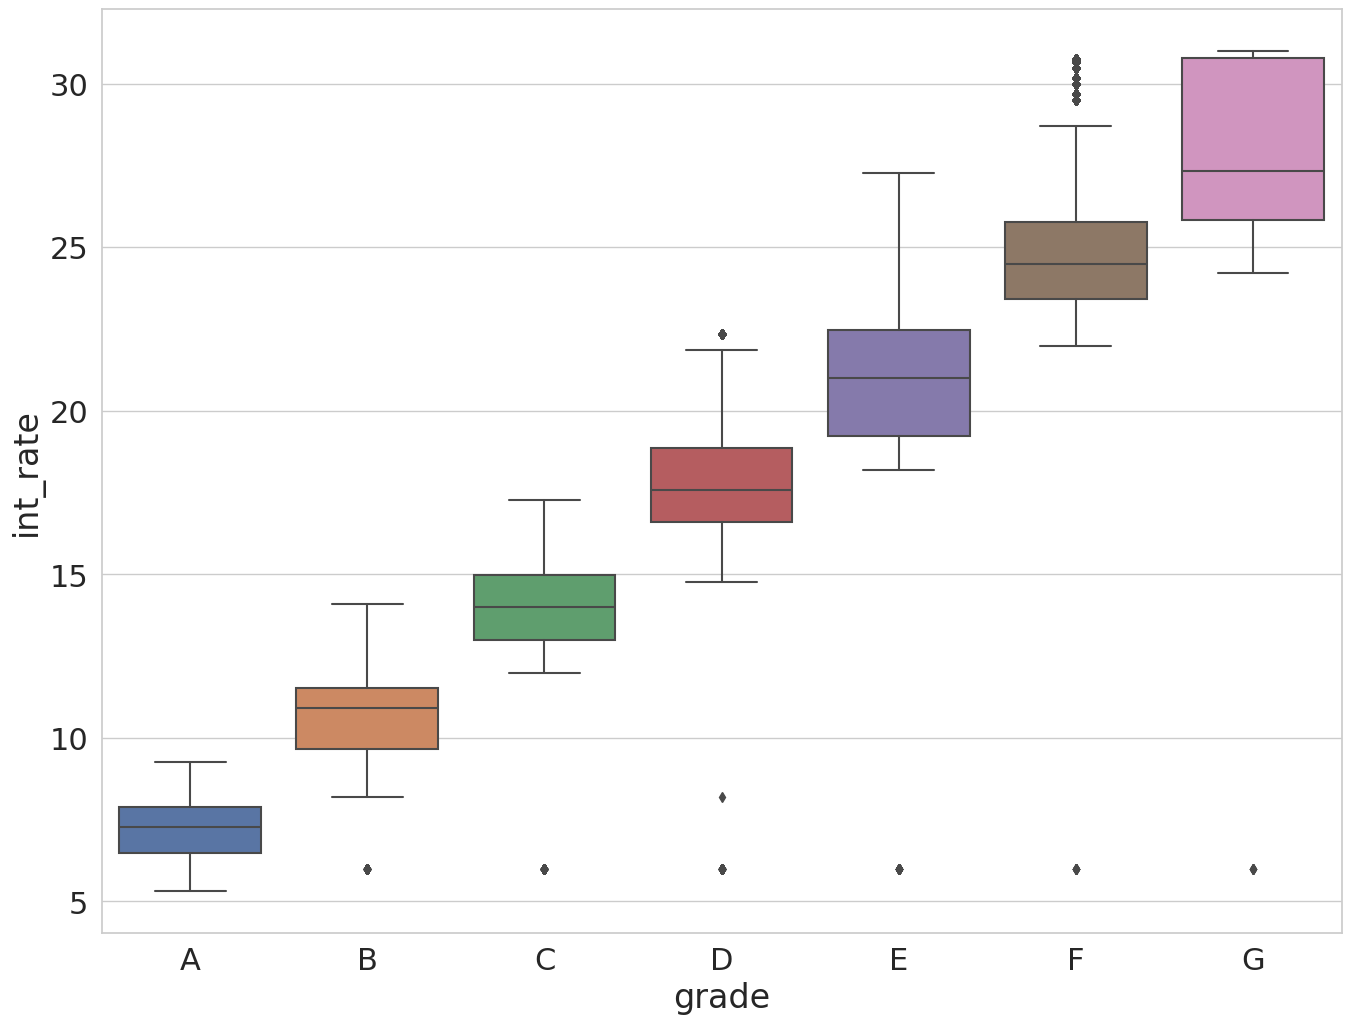

In [39]:
temp = temp.sort_values('grade')
plt.figure(figsize = (16,12))
sns.boxplot(data = temp, x = 'grade', y = 'int_rate')

<Axes: xlabel='sub_grade', ylabel='int_rate'>

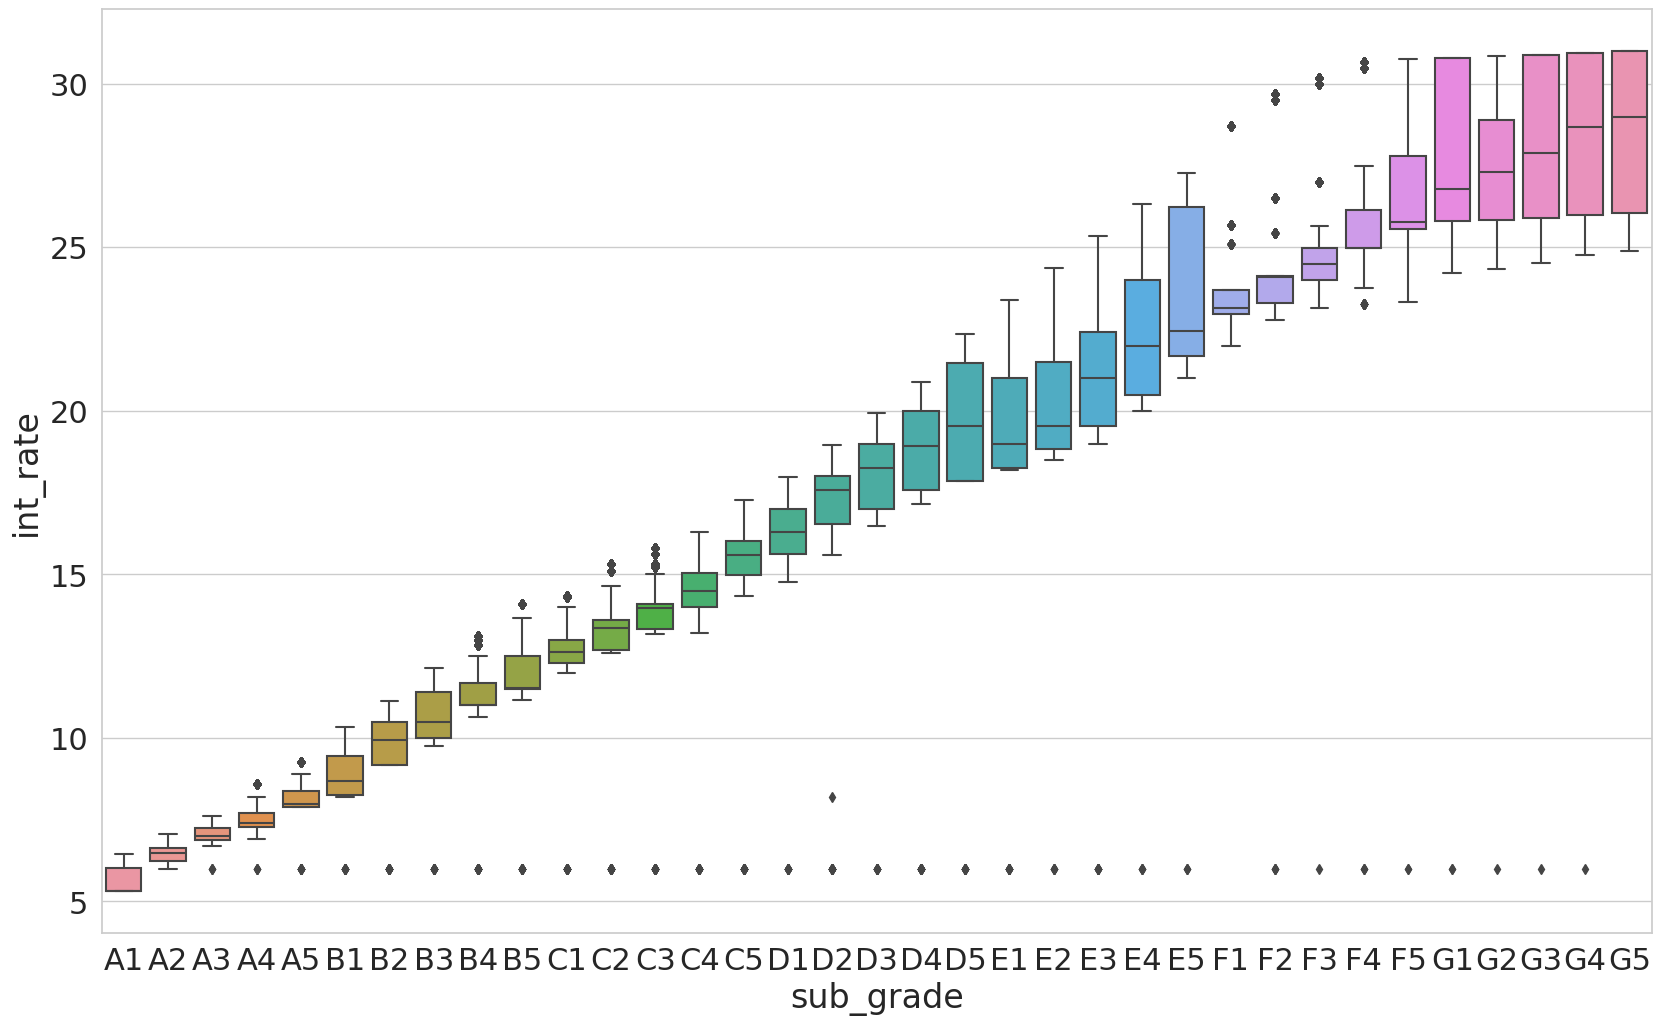

In [40]:
temp = temp.sort_values('sub_grade')
plt.figure(figsize = (20,12))
sns.boxplot(data = temp, x = 'sub_grade', y = 'int_rate')

In [41]:
# Change predicted value into binary numerical value 0,1
status_values = {'Fully Paid': 0, 'Charged Off': 1}
df['loan_status'] = df.loan_status.map(status_values)

Text(0.5, 1.0, 'correlation with loan status')

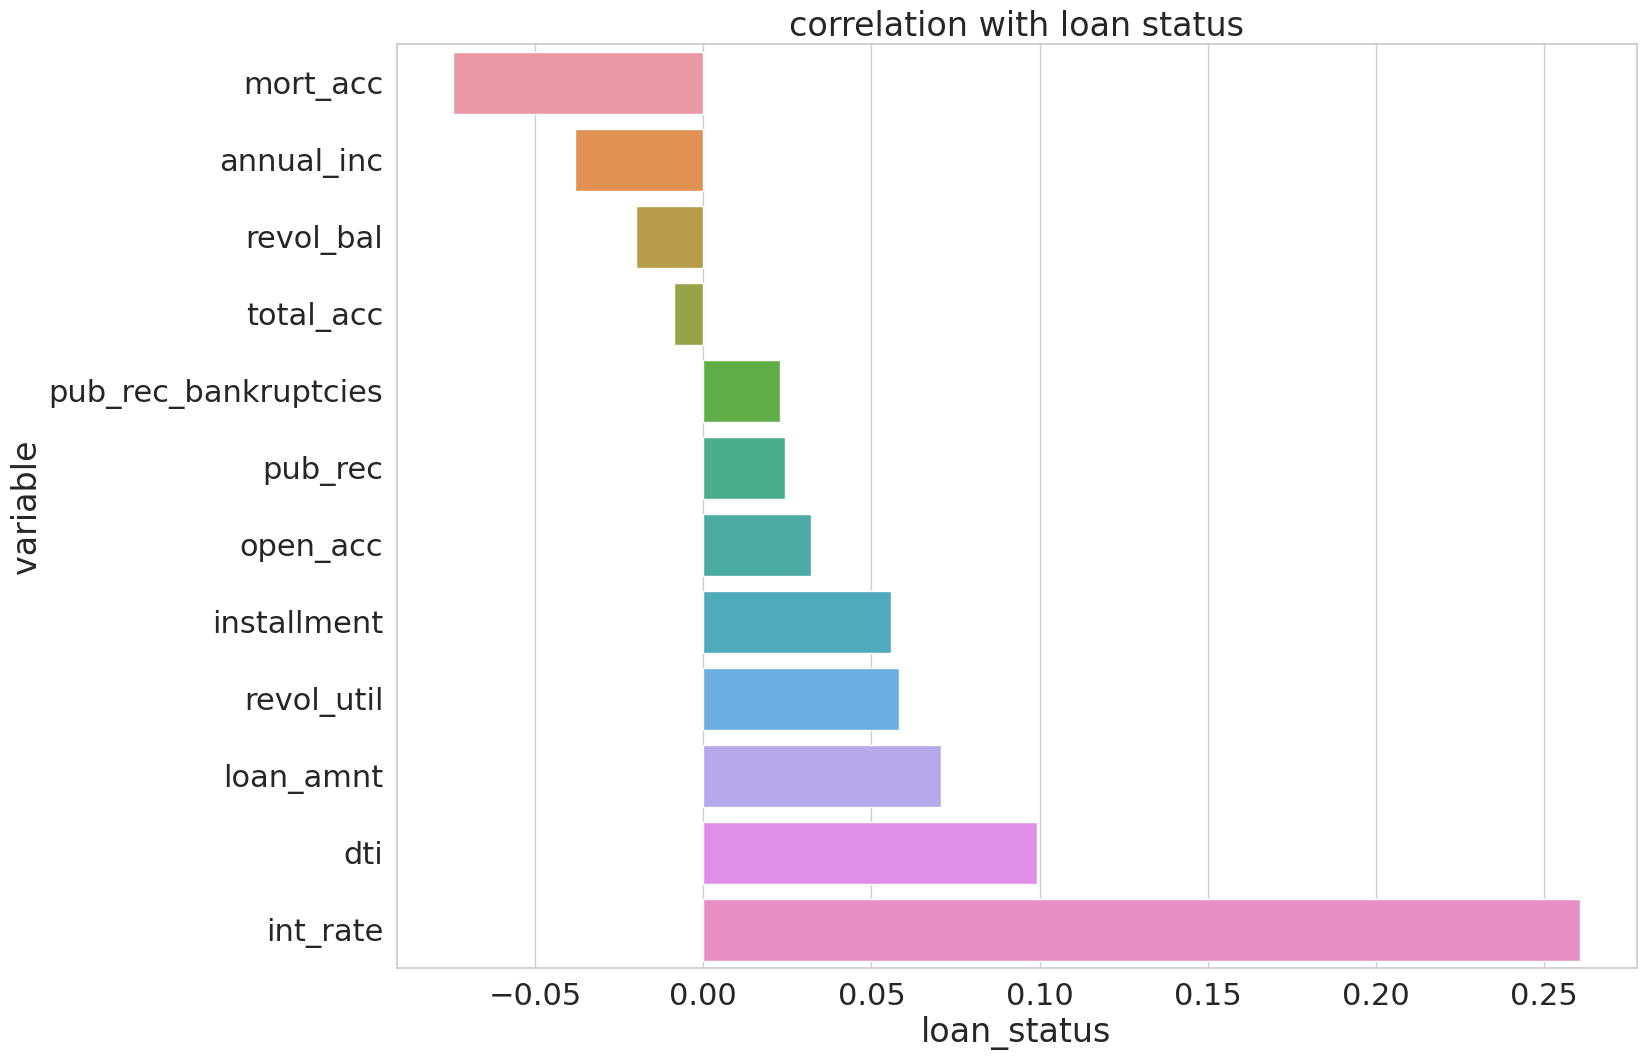

In [48]:
cor = pd.DataFrame(df.corr(numeric_only=True)['loan_status'].drop('loan_status').sort_values())
cor['variable'] = cor.index

plt.figure(figsize = (16,12))
sns.barplot(
    x="loan_status", 
    y="variable", 
    data=cor, 
    estimator=sum
);
plt.title('correlation with loan status')


In [51]:
df.reset_index(inplace = True)

# Data cleaning

In [88]:
loan_train = pd.read_csv('%s/loan_train_07_18.csv'%(_DATA_DIR), index_col =0)

# Data preprocessing, change string type x % to x.

loan_train.revol_util = loan_train.revol_util.apply(lambda x: str(x)[:-1])
loan_train.revol_util = loan_train.revol_util.replace('na','0')
loan_train.revol_util = loan_train.revol_util.astype(np.float64)

# Change predicted value into binary numerical value 0,1
status_values = {'Fully Paid': 0, 'Charged Off': 1}
loan_train['loan_status'] = loan_train.loan_status.map(status_values)


from Data_cleaning import Data_cleaning, Data_cleaning_grade
loan_train_cleaned = Data_cleaning(loan_train)


In [89]:
# Clean test dataset
loan_test = pd.read_csv('%s/loan_test_19_20.csv'%(_DATA_DIR), index_col =0)

loan_test.int_rate = loan_test.int_rate.apply(lambda x: float(x[:-1]))
loan_test.revol_util = loan_test.revol_util.apply(lambda x: str(x)[:-1])
loan_test.revol_util = loan_test.revol_util.replace('na','0')
loan_test.revol_util = loan_test.revol_util.astype(np.float64)


from Data_cleaning import Data_cleaning, Data_cleaning_grade
loan_test_cleaned = Data_cleaning(loan_test)

status_values = {'Fully Paid': 0, 'Charged Off': 1}
loan_test_cleaned ['loan_status'] = loan_test_cleaned .loan_status.map(status_values)


In [90]:
loan_train_cleaned.loan_status.mean()

0.1963565976126903

In [91]:
loan_test_cleaned.loan_status.mean()

0.19311832216143168

In [92]:
grade_col = np.unique(loan_train[['grade']])
subgrade_col = np.unique(loan_train[['sub_grade']])

In [93]:
from sklearn.linear_model import LogisticRegression

def Model_construction(X_train,y_train,method,penalty):
    
    Xscaler = StandardScaler().fit(X_train) 
    X_train = Xscaler.transform(X_train)    
    
    if method == 'Imbalanced':
        if  penalty == 'l1':
            lr_model = LogisticRegression(class_weight='balanced',penalty = 'l1',solver ='saga').fit(X_train,y_train)
        if penalty == 'none':  
            lr_model = LogisticRegression(class_weight='balanced').fit(X_train,y_train)
    
    if method == 'Null':
        if penalty == 'l1':
            lr_model = LogisticRegression(penalty = 'l1',solver ='saga').fit(X_train,y_train)
        if penalty == 'none':
            lr_model = LogisticRegression(penalty = 'none').fit(X_train,y_train)
    
    return lr_model, Xscaler

In [94]:
X_train = loan_train_cleaned.drop(columns = ['int_rate','loan_status','grade','sub_grade','id'])
y_train = loan_train_cleaned.loan_status

X_test = loan_test_cleaned.drop(columns = ['int_rate','loan_status','grade','sub_grade','id'])
y_test = loan_test_cleaned.loan_status

In [95]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

Xscaler = StandardScaler().fit(X_train) 
X_train = Xscaler.transform(X_train)  

lr_model = LogisticRegression(penalty = 'none').fit(X_train,y_train)

X_test =  Xscaler.transform(X_test)  

y_pred = lr_model.predict(X_test)
    


In [96]:
df_summary = pd.DataFrame({'Grade': loan_test_cleaned.grade,'Sub_Grade':loan_test_cleaned.sub_grade,'True':y_test,'Predict':y_pred})

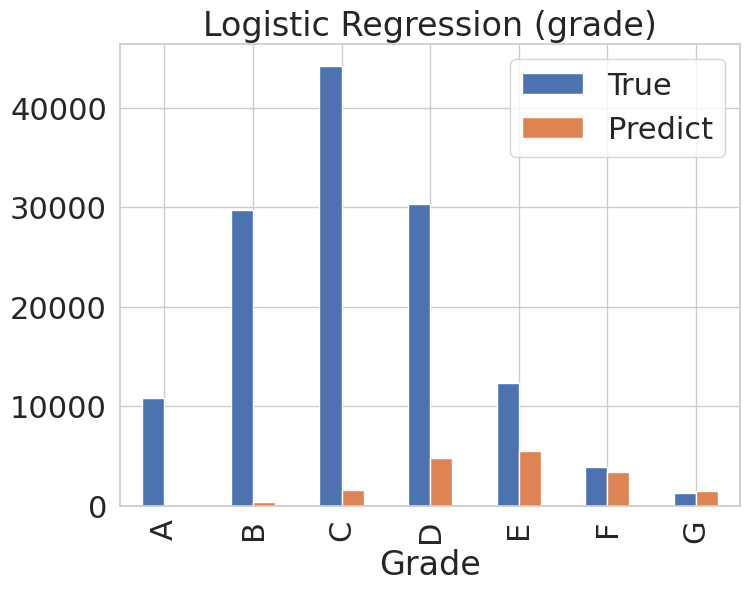

In [97]:
df_summary.groupby('Grade').sum().plot(kind ='bar', figsize = (8,6))
plt.title('Logistic Regression (grade)')
plt.savefig('lg_grade.pdf')

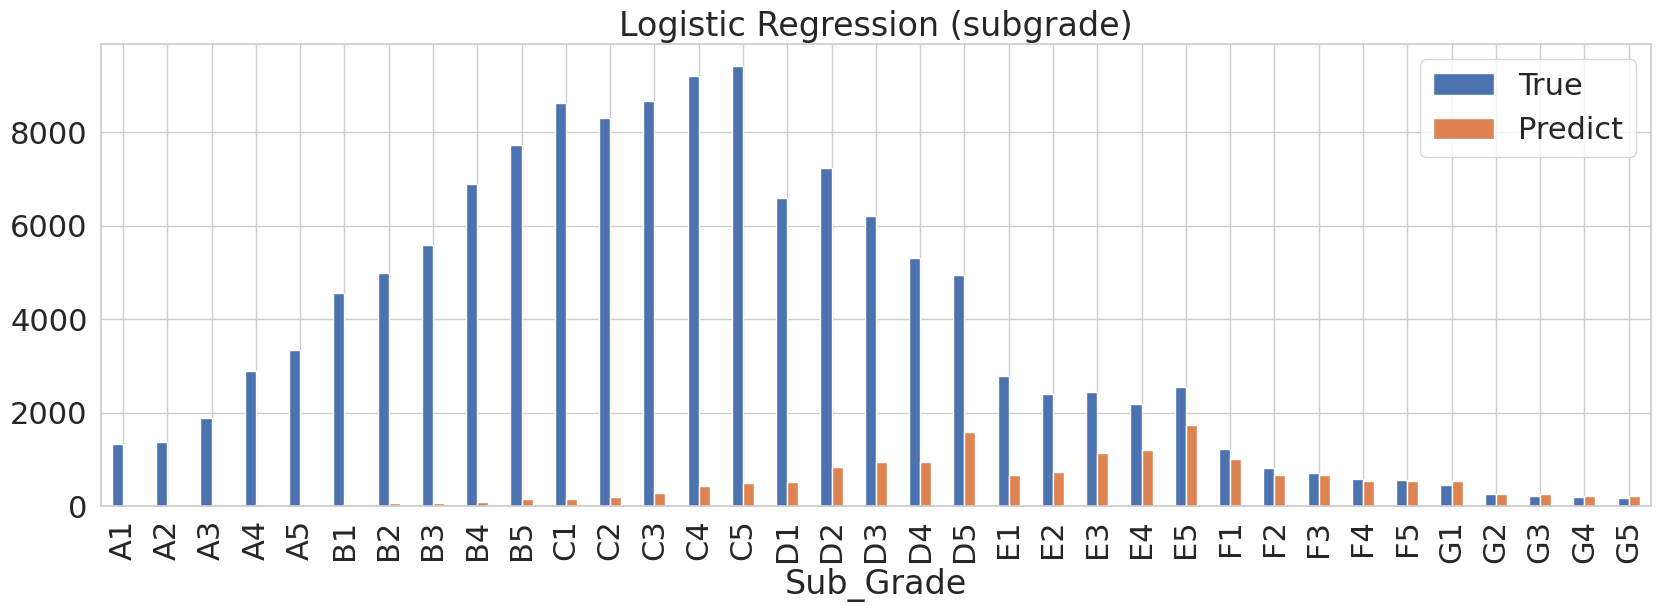

In [98]:
df_summary.groupby('Sub_Grade').sum().plot(kind ='bar', figsize = (20,6))
plt.title('Logistic Regression (subgrade)')
plt.savefig('lg_subgrade.pdf')

In [99]:
# Lasso
lr_model = LogisticRegression(penalty = 'l1',solver = 'saga',C=100).fit(X_train,y_train)

X_test =  Xscaler.transform(X_test)  

y_pred = lr_model.predict(X_test)

df_summary_lasso = pd.DataFrame({'Grade': loan_test_cleaned.grade,'Sub_Grade':loan_test_cleaned.sub_grade,'True':y_test,'Predict':y_pred})
    

Text(0.5, 1.0, 'Logistic Regression, Lasso(grade)')

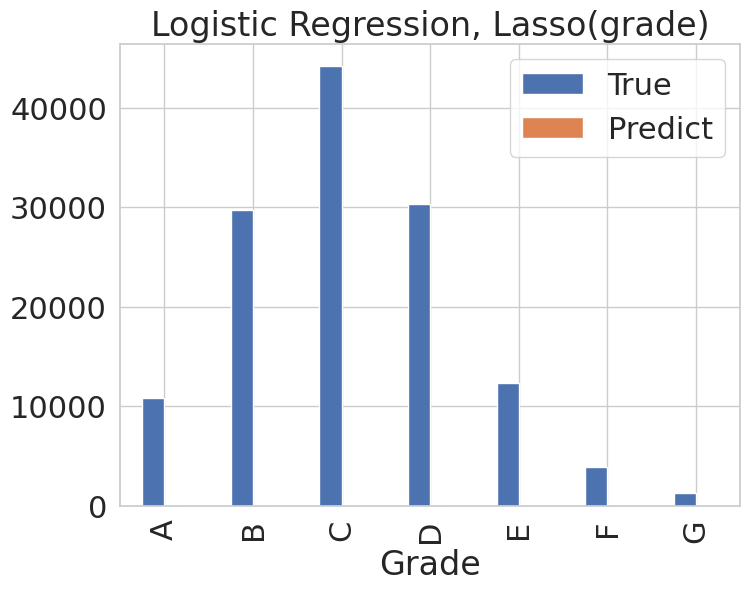

In [100]:
df_summary_lasso.groupby('Grade').sum().plot(kind ='bar', figsize = (8,6))
plt.title('Logistic Regression, Lasso(grade)')

In [101]:
df_summary_lasso.groupby('Grade').sum()

,Sub_Grade,True,Predict
Grade,,,
A,A4A1A1A3A4A5A4A3A4A1A5A1A2A5A4A1A1A5A5A2A2A5A4...,10825,20
B,B2B5B5B5B1B2B3B4B3B3B3B1B3B3B2B1B4B5B1B2B1B1B2...,29750,28
C,C4C5C1C5C3C1C4C4C2C5C5C5C3C2C3C1C3C1C2C1C1C1C1...,44210,16
D,D1D2D5D2D2D3D2D3D4D2D2D3D3D1D3D4D2D5D2D1D3D3D2...,30274,16
E,E1E4E4E4E3E4E5E1E4E3E5E2E1E5E5E4E1E2E2E2E2E3E2...,12356,6
F,F2F2F3F4F1F1F3F2F2F2F1F1F2F1F1F1F3F5F5F1F2F3F2...,3896,3
G,G4G3G2G1G4G4G3G5G2G5G1G4G2G1G4G3G3G3G3G2G1G1G1...,1302,0


Text(0.5, 1.0, 'Logistic Regression, Lasso (subgrade)')

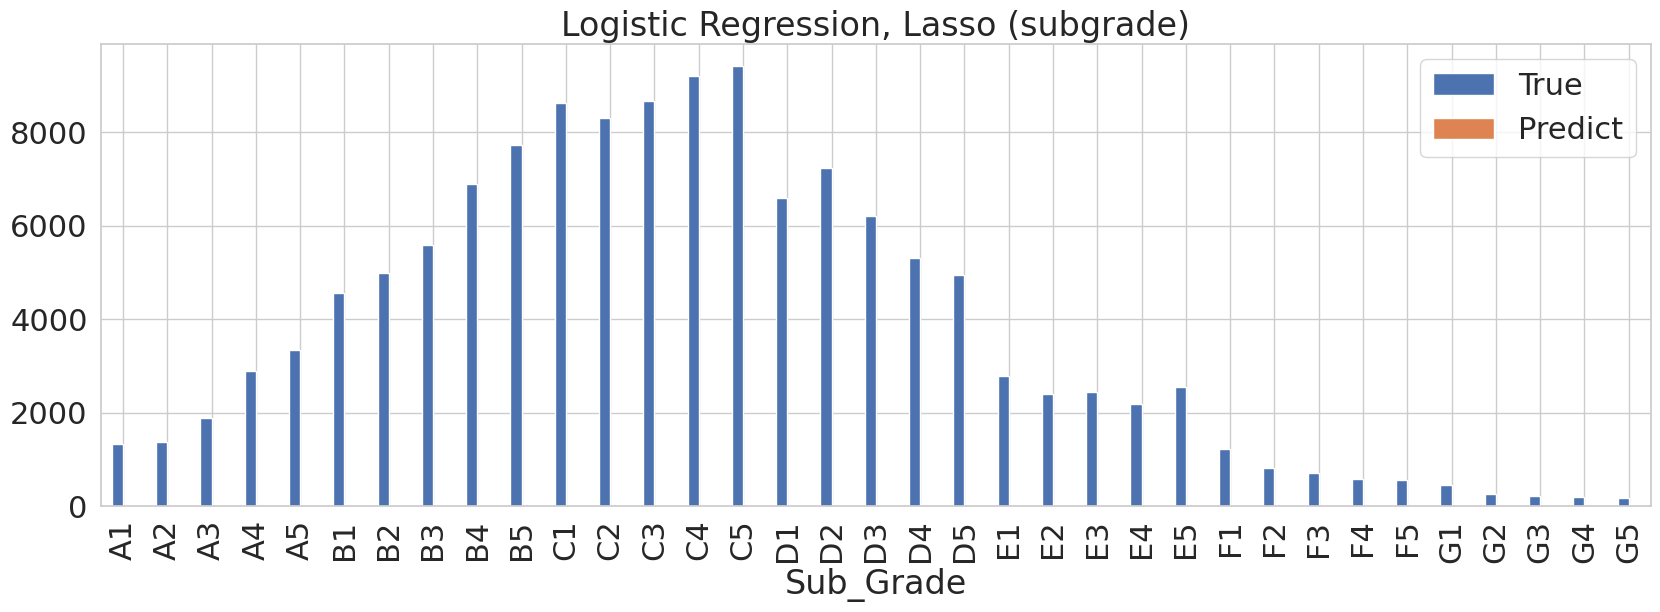

In [102]:
df_summary_lasso.groupby('Sub_Grade').sum().plot(kind ='bar', figsize = (20,6))
plt.title('Logistic Regression, Lasso (subgrade)')

In [103]:
# Two variable logistic regression
X_train_2 = loan_train_cleaned[['mort_acc','dti']]

X_test_2 = loan_test_cleaned[['mort_acc','dti']]


lr_model = LogisticRegression(penalty = 'none').fit(X_train_2,y_train)


y_pred = lr_model.predict(X_test_2)
    

df_summary_2 = pd.DataFrame({'Grade': loan_test_cleaned.grade,'Sub_Grade':loan_test_cleaned.sub_grade,'True':y_test,'Predict':y_pred})
 

Text(0.5, 1.0, 'Logistic Regression, 2 variables (grade)')

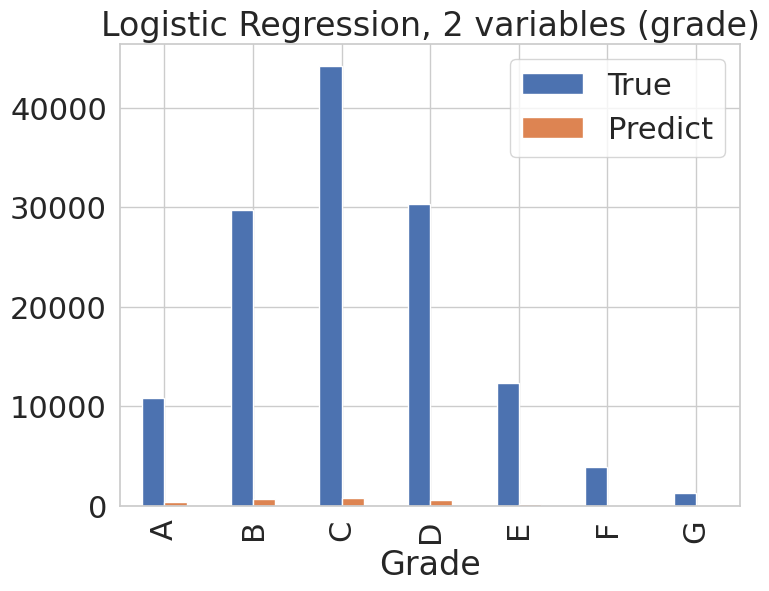

In [104]:
df_summary_2.groupby('Grade').sum().plot(kind ='bar', figsize = (8,6))
plt.title('Logistic Regression, 2 variables (grade)')

Text(0.5, 1.0, 'Logistic Regression, 2 variables (subgrade)')

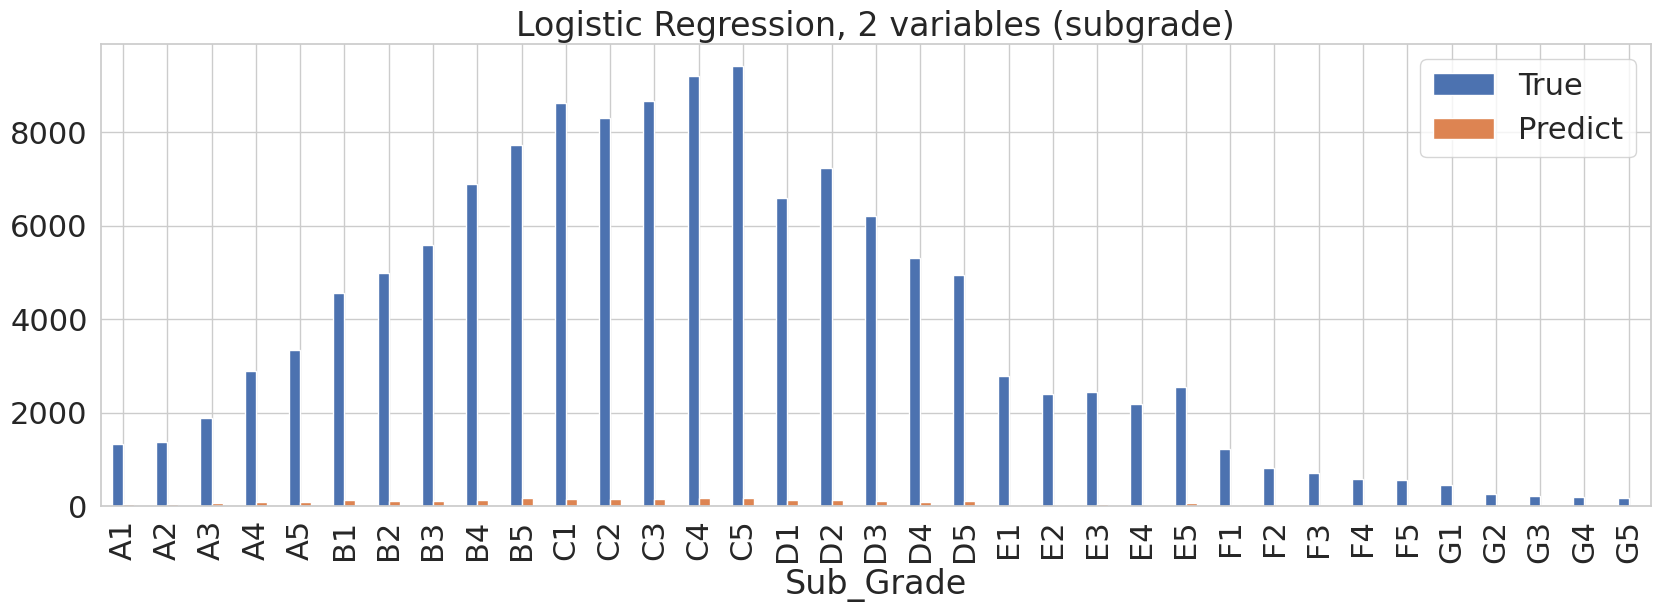

In [105]:
df_summary_2.groupby('Sub_Grade').sum().plot(kind ='bar', figsize = (20,6))
plt.title('Logistic Regression, 2 variables (subgrade)')

# KNN with sklearn

In [106]:
knn_train = loan_train_cleaned[['id','loan_status','mort_acc','dti','grade','sub_grade']]

knn_test = loan_test_cleaned [['id','loan_status','mort_acc','dti','grade','sub_grade']]


In [107]:
# standardize

# X = df_knn.drop(columns = 'loan_status')
X_train = knn_train[['mort_acc','dti']]
y_train = knn_train[['loan_status']]

Xscaler = StandardScaler().fit(X_train) 
X_train = Xscaler.transform(X_train)


X_test = knn_test[['mort_acc','dti']]
y_test = knn_test[['loan_status']]


X_test = Xscaler.transform(X_test)

nn1 = KNeighborsClassifier(n_neighbors=1,n_jobs=-1).fit(X_train, y_train)
nn5 = KNeighborsClassifier(n_neighbors=5,n_jobs=-1).fit(X_train, y_train)
nn20 = KNeighborsClassifier(n_neighbors=20,n_jobs=-1).fit(X_train, y_train)

y_pred_1 = nn1.predict(X_test) 
y_pred_5 = nn5.predict(X_test) 
y_pred_20 = nn20.predict(X_test)



In [108]:
knn_result = pd.DataFrame(columns = ['Grade','Sub_Grade','True','1-nn','5-nn','20-nn'])

knn_result.loc[:,'Grade'] = knn_test.loc[:,'grade']
knn_result.loc[:,'Sub_Grade'] = knn_test.loc[:,'sub_grade']
knn_result.loc[:,'True'] = y_test.loan_status
knn_result.loc[:,'1-nn'] = y_pred_1 
knn_result.loc[:,'5-nn'] = y_pred_5
knn_result.loc[:,'20-nn'] = y_pred_20

<Axes: xlabel='Grade'>

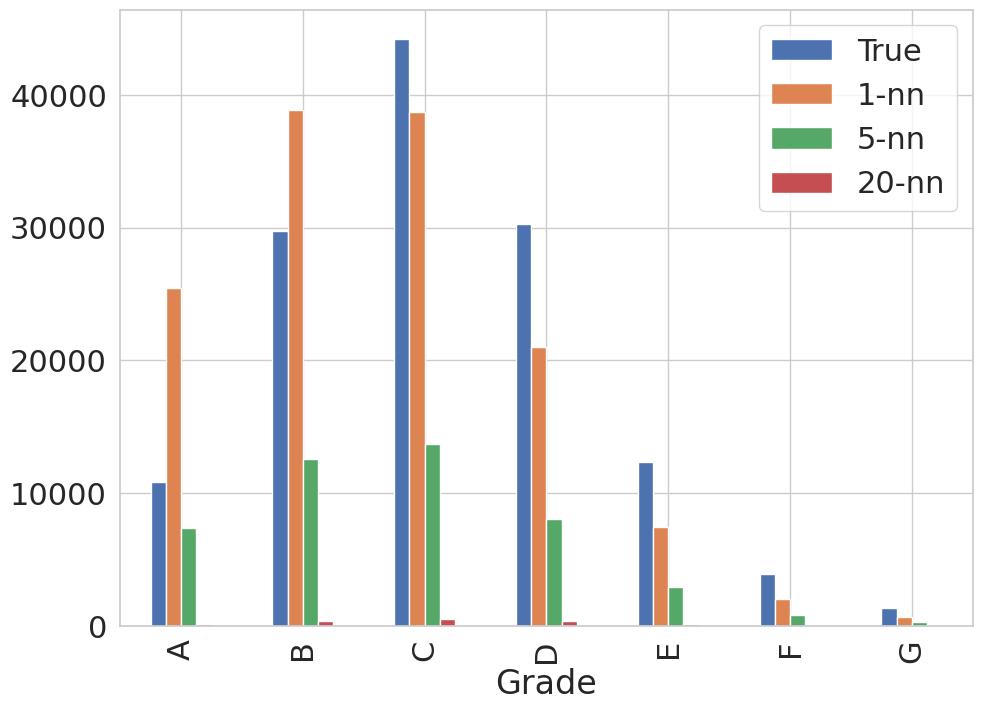

In [109]:
knn_result.groupby('Grade').sum().plot(kind = 'bar')

<Axes: xlabel='Sub_Grade'>

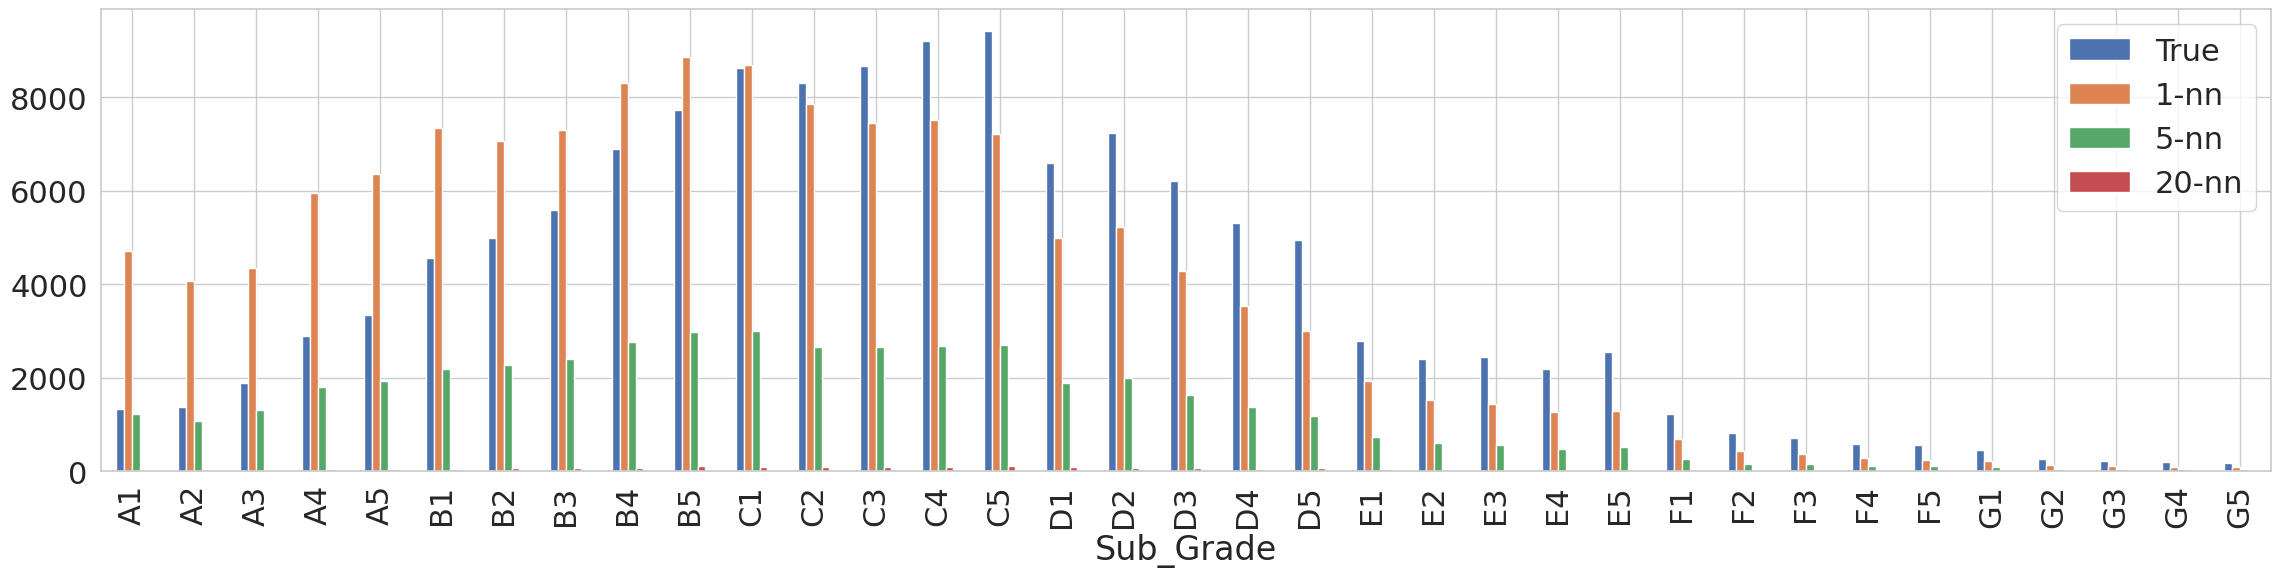

In [110]:
knn_result.groupby('Sub_Grade').sum().plot(kind = 'bar', figsize = (28,6))

# Model evaluation

## Confusion matrix

In [116]:
knn_result['1-nn'].astype(int)

0         0
1         0
2         1
3         0
4         0
         ..
105446    0
105447    0
105448    0
105449    0
105450    1
Name: 1-nn, Length: 686693, dtype: int64

In [117]:
# Construct the confusion matrix
CM_1 = confusion_matrix(y_test.loan_status,knn_result['1-nn'].astype(int))
CM_5 =  confusion_matrix(y_test.loan_status,knn_result['5-nn'].astype(int))
CM_20 =  confusion_matrix(y_test.loan_status,knn_result['20-nn'].astype(int))

# Calculate Accuracy
Acc_1 = (CM_1[0,0] + CM_1[1,1])/CM_1.sum()
Acc_5 = (CM_5[0,0] + CM_5[1,1])/CM_5.sum()
Acc_20 = (CM_20[0,0] + CM_20[1,1])/CM_20.sum()

# Calculate FPR & FNR

FPR_1 = CM_1[0,1] / (CM_1[0,1]+CM_1[0,0])
FPR_5 = CM_5[0,1] / (CM_5[0,1]+CM_5[0,0])
FPR_20 = CM_20[0,1] / (CM_20[0,1]+CM_20[0,0])


FNR_1 = CM_1[1,0] / (CM_1[1,0]+CM_1[1,1])
FNR_5 = CM_5[1,0] / (CM_5[1,0]+CM_5[1,1])
FNR_20 = CM_20[1,0] / (CM_20[1,0]+CM_20[1,1])


print('---Calculate Accuracy---')
print('1-NN:', Acc_1)
print('5-NN:', Acc_5)
print('20-NN:', Acc_20)
print('------------------------')
print('-----Calculate FPR------')
print('1-NN:', FPR_1)
print('5-NN:', FPR_5)
print('20-NN:', FPR_20)
print('------------------------')
print('-----Calculate FNR------')
print('1-NN:', FNR_1)
print('5-NN:', FNR_5)
print('20-NN:', FNR_20)
print('------------------------')


---Calculate Accuracy---
1-NN: 0.6916278453399117
5-NN: 0.7693874846547147
20-NN: 0.8058797745135017
------------------------
-----Calculate FPR------
1-NN: 0.19241084319953797
5-NN: 0.06436254692463182
20-NN: 0.0019437626335547214
------------------------
-----Calculate FNR------
1-NN: 0.7928785262380008
5-NN: 0.9252335743856183
20-NN: 0.9970666525906209
------------------------


In [118]:
CM_5

array([[518418,  35662],
       [122698,   9915]])

In [119]:
CM_20

array([[553003,   1077],
       [132224,    389]])

In [120]:
# Logistic regression result

lg_null = confusion_matrix(y_test.loan_status,df_summary.Predict)
lg_2 =  confusion_matrix(y_test.loan_status,df_summary_2.Predict)
lg_lasso =  confusion_matrix(y_test.loan_status,df_summary_lasso.Predict)

# Calculate Accuracy
Acc_lg_null = (lg_null[0,0] + lg_null[1,1])/lg_null.sum()
Acc_lg_2 = (lg_2[0,0] + lg_2[1,1])/lg_2.sum()
Acc_lg_lasso = (lg_lasso[0,0] + lg_lasso[1,1])/lg_lasso.sum()

# Calculate FPR & FNR

FPR_null = lg_null[0,1] / (lg_null[0,1]+lg_null[0,0])
FPR_2 = lg_2[0,1] / (lg_2[0,1]+lg_2[0,0])
FPR_lasso = lg_lasso[0,1] / (lg_lasso[0,1]+lg_lasso[0,0])


FNR_null = lg_null[1,0] / (lg_null[1,0]+lg_null[1,1])
FNR_2 = CM_5[1,0] / (lg_2[1,0]+lg_2[1,1])
FNR_lasso = lg_lasso[1,0] / (lg_lasso[1,0]+lg_lasso[1,1])

print('---Calculate Accuracy---')
print('Logistic regression (plain):',Acc_lg_null)
print('Logistic regression 2 variables:', Acc_lg_2)
print('Logistic regression lasso:', Acc_lg_lasso)
print('------------------------')
print('-----Calculate FPR------')
print('Logistic regression (plain):',FPR_null)
print('Logistic regression 2 variables:', FPR_2)
print('Logistic regression lasso:', FPR_lasso)
print('------------------------')
print('-----Calculate FNR------')
print('Logistic regression (plain):',FNR_null)
print('Logistic regression 2 variables:', FNR_2)
print('Logistic regression lasso:', FNR_lasso)



---Calculate Accuracy---
Logistic regression (plain): 0.8052302848580078
Logistic regression 2 variables: 0.8053584352833071
Logistic regression lasso: 0.8068044963324222
------------------------
-----Calculate FPR------
Logistic regression (plain): 0.016575223794397922
Logistic regression 2 variables: 0.003333453652902108
Logistic regression lasso: 0.00012814034074501877
------------------------
-----Calculate FNR------
Logistic regression (plain): 0.9392970523251868
Logistic regression 2 variables: 0.9252335743856183
Logistic regression lasso: 0.9998642667008514


In [121]:
lg_null

array([[544896,   9184],
       [124563,   8050]])

## ROC & AUC

In [122]:
# Logistic regression
Xscaler = StandardScaler().fit(X_train) 
X_train = Xscaler.transform(X_train)  

lr_model = LogisticRegression(penalty = 'none').fit(X_train,y_train)

X_test =  Xscaler.transform(X_test)  

y_pred_pro = lr_model.predict_proba(X_test)[:,1]

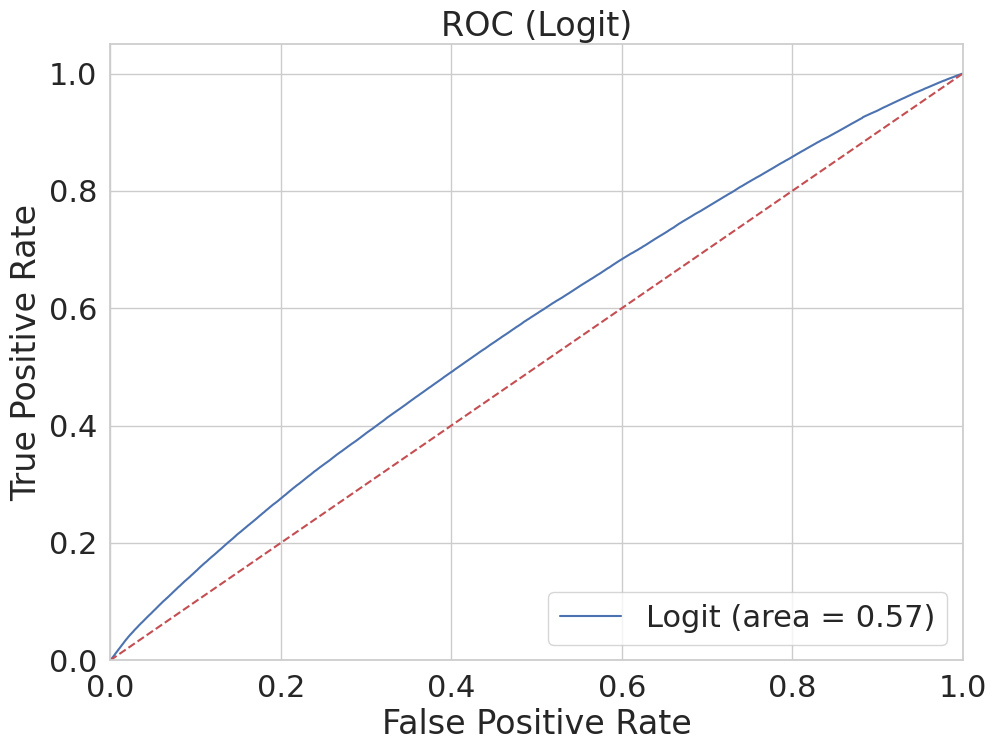

In [123]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_pro)

roc_auc = auc(fpr,tpr)

plt.figure()
plt.plot(fpr, tpr, label='Logit (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Logit)')
plt.legend(loc='lower right')
plt.savefig('ROC.pdf')

In [124]:
# Logistic regression with Lasso
lr_model = LogisticRegression(penalty = 'l1',solver = 'saga').fit(X_train,y_train)

X_test =  Xscaler.transform(X_test)  

y_pred_pro_lasso = lr_model.predict_proba(X_test)[:,1]

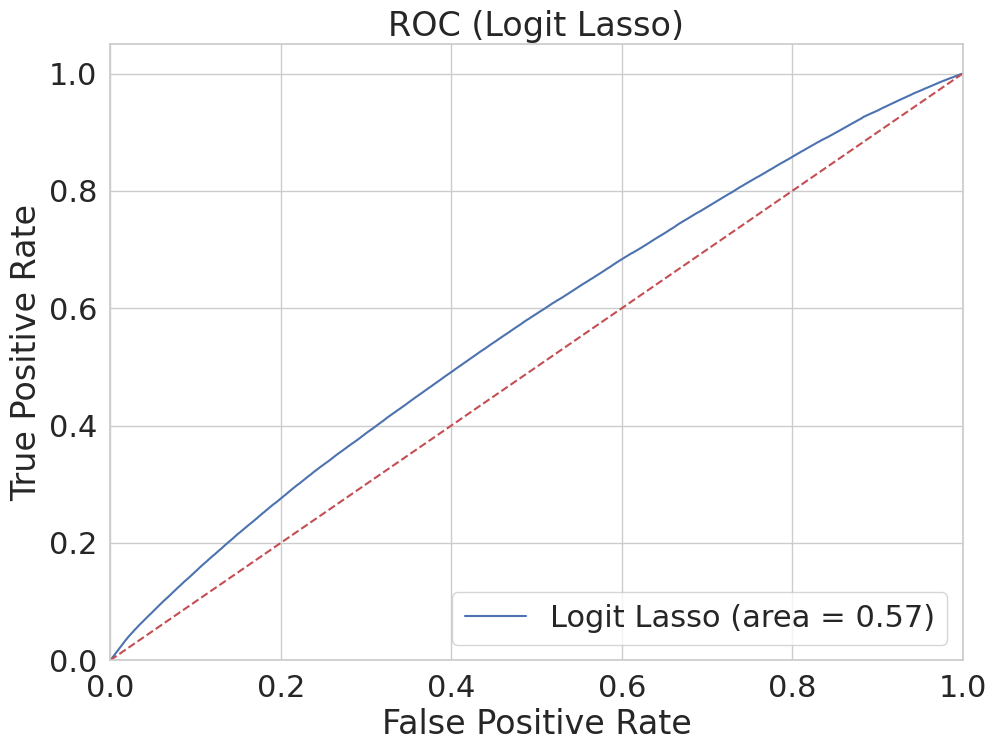

In [125]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_pro_lasso)

roc_auc = auc(fpr,tpr)

plt.figure()
plt.plot(fpr, tpr, label='Logit Lasso (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Logit Lasso)')
plt.legend(loc='lower right')
#plt.savefig('ROC.pdf')

In [126]:
# Two variable logistic regression
lr_model = LogisticRegression(penalty = 'none').fit(X_train_2,y_train)


y_pred_prob_2 = lr_model.predict_proba(X_test_2)[:,1]    

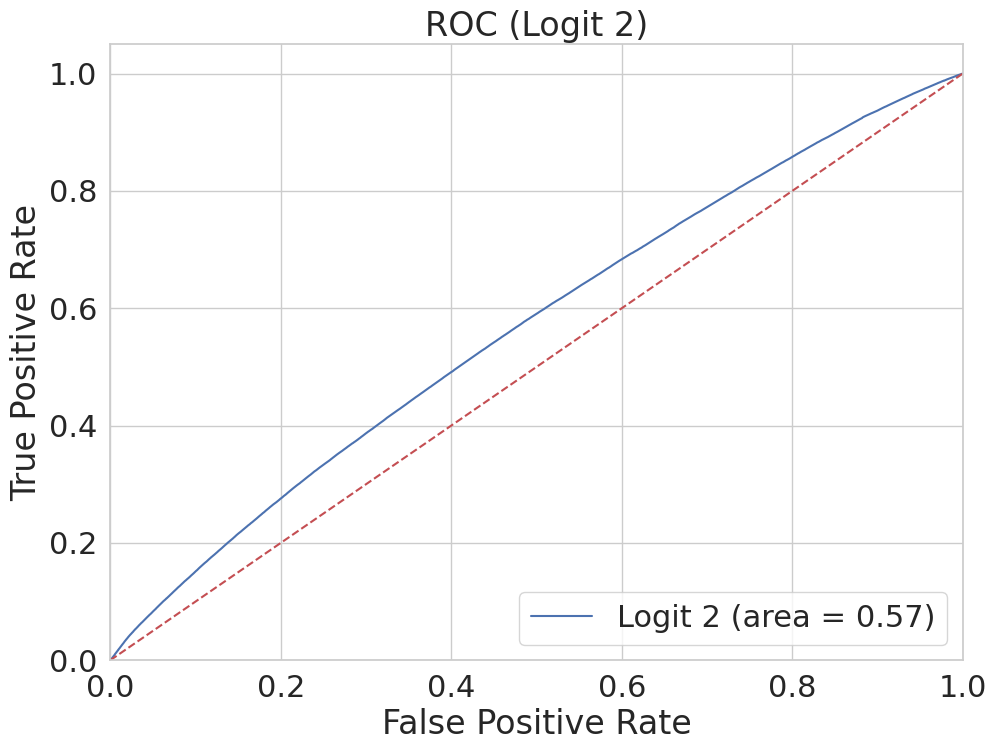

In [127]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_2)

roc_auc = auc(fpr,tpr)

plt.figure()
plt.plot(fpr, tpr, label='Logit 2 (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Logit 2)')
plt.legend(loc='lower right')
#plt.savefig('ROC.pdf')

# Multinomial Logistic Regression

In [128]:
import random
from data_utils import load_CIFAR10

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'



In [129]:
# Load data
Xtr, Ytr, Xte, Yte = load_CIFAR10(_DATA_DIR+'/cifar-10-data') 

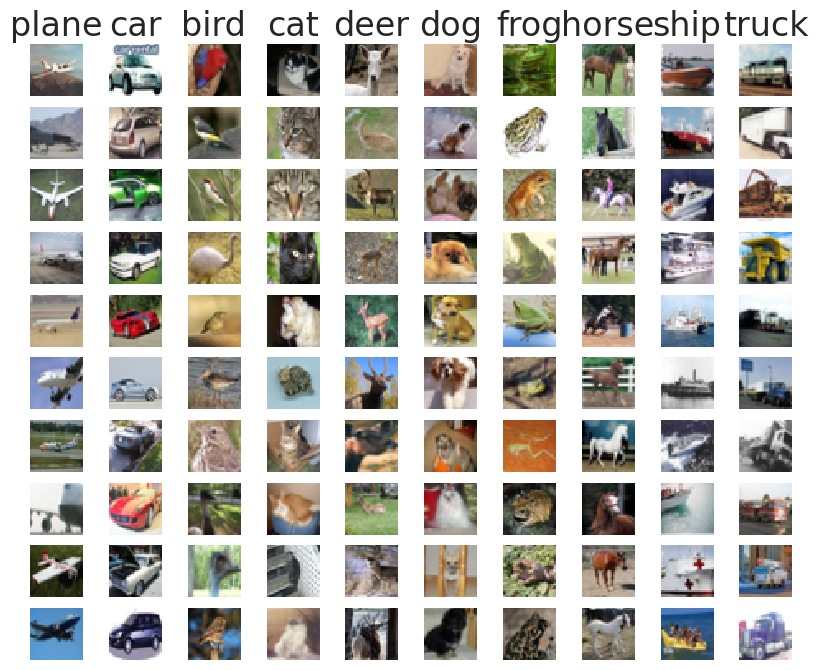

In [130]:
# Visualize some examples from the dataset.
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(Ytr== y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(Xtr[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

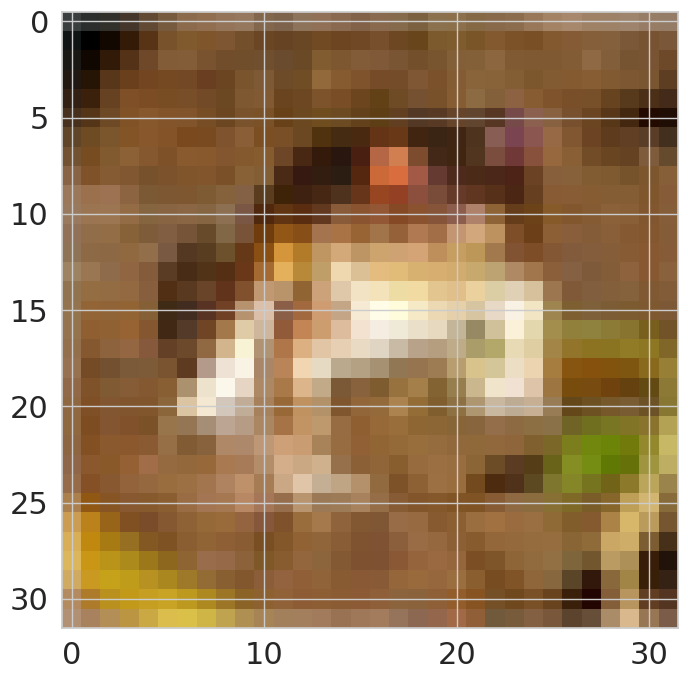

In [131]:
# Data example
# It's a frog
plt.imshow(Xtr[0]/255)

In [132]:
classes[Ytr[0]]

'frog'

In [133]:
# flatten out all images to be one-dimensional
Xtr_rows = Xtr.reshape(Xtr.shape[0], 32 * 32 * 3) # Xtr_rows becomes 50000 x 3072
Xte_rows = Xte.reshape(Xte.shape[0], 32 * 32 * 3) # Xte_rows becomes 10000 x 3072

In [134]:
# logistic regression
from sklearn.linear_model import LogisticRegression
MLR = LogisticRegression(multi_class='multinomial', solver='saga',random_state=0,penalty = 'none')
MLR.fit(Xtr_rows[:5000], Ytr[:5000])

y_pred_MLR = MLR.predict(Xte_rows[:1000])

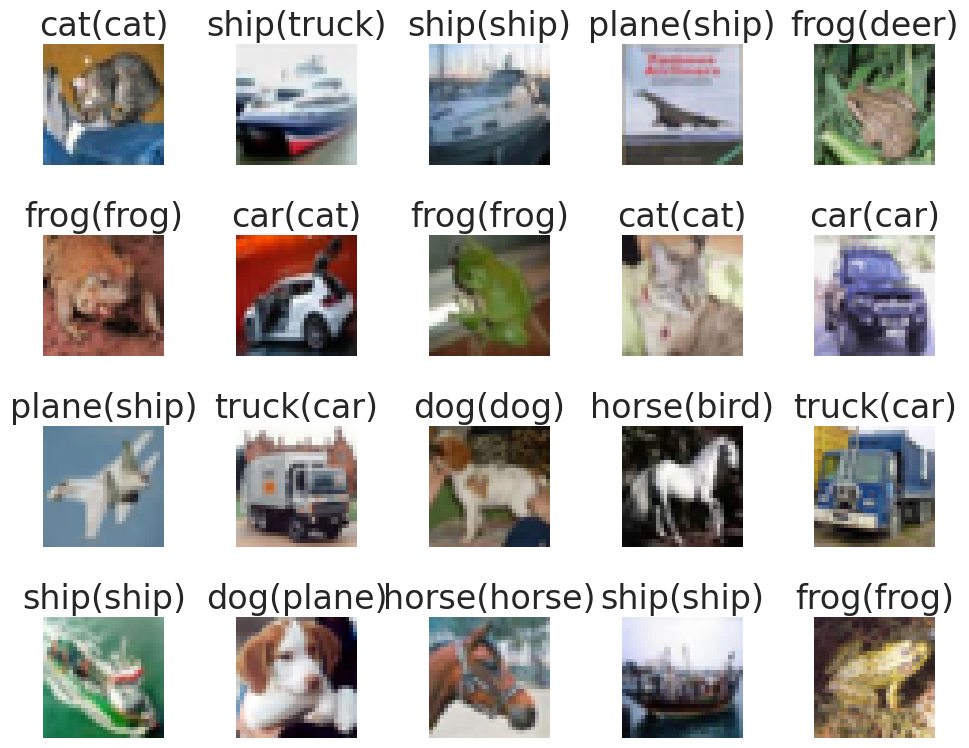

In [135]:
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(Xte[i]/255)
    plt.title(classes[Yte[i]]+'('+classes[y_pred_MLR[i]]+')')
    plt.axis('off')
plt.tight_layout()

In [136]:
CIFAR10_result = pd.DataFrame({'True':Yte[:1000],'Predict':y_pred_MLR})
CIFAR10_result['Correct'] = CIFAR10_result.iloc[:,0] - CIFAR10_result.iloc[:,1]
Acc_cifar = (CIFAR10_result['Correct'] == 0).sum()/CIFAR10_result.shape[0]

In [137]:
Acc_cifar 

0.334

In [138]:
# Top 5 error
y_pred_prob = MLR.predict_proba(Xte_rows[:1000])

predict_prob = pd.DataFrame(y_pred_prob)
predict_prob.columns = classes

In [139]:
predict_prob

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,0.021014,0.188227,0.157244,0.352709,0.003062,0.019604,0.123683,0.000877,0.133507,0.000074
1,0.023289,0.152691,0.026497,0.011955,0.002931,0.002541,0.000289,0.000909,0.108290,0.670607
2,0.302096,0.074267,0.055328,0.035290,0.002804,0.035317,0.001594,0.008702,0.316940,0.167662
3,0.183161,0.014421,0.140843,0.023193,0.057845,0.075972,0.003896,0.204206,0.268059,0.028404
4,0.007070,0.029614,0.071359,0.005303,0.810437,0.023798,0.007290,0.012639,0.030594,0.001897
...,...,...,...,...,...,...,...,...,...,...
995,0.081639,0.047239,0.095909,0.041384,0.085904,0.041121,0.069389,0.512161,0.001114,0.024141
996,0.270766,0.027977,0.136682,0.018511,0.020501,0.030782,0.007460,0.036350,0.125133,0.325839
997,0.119362,0.089789,0.366755,0.005659,0.037534,0.195427,0.004559,0.016499,0.038214,0.126203
998,0.058912,0.282285,0.136665,0.071686,0.036601,0.180905,0.014772,0.162419,0.016443,0.039313


In [140]:
Top_5 = pd.DataFrame(np.argsort(y_pred_prob)[:,-5:])
Top_5['True'] = Yte[:1000]
Top_5['Correct'] = (Top_5['True'] - Top_5[4]) * (Top_5['True'] - Top_5[3]) * (Top_5['True'] - Top_5[2]) * (Top_5['True'] - Top_5[1]) * (Top_5['True']-Top_5[0])
(Top_5['Correct'] == 0).sum()/Top_5.shape[0]

0.846